# Waffle Charts, Word Clouds, and Regression Plots

## Setup

### Importing Required Libraries

In [1]:
# %pip install wordcloud pywaffle

In [2]:
from wordcloud import WordCloud, STOPWORDS, __version__ as wc_version
from pywaffle import Waffle
from PIL import Image

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import pandas as pd
import numpy as np
import os

%matplotlib inline

In [3]:
plt.style.use("ggplot")

print("matplotlib version: ", mpl.__version__)
print("seaborn version: ", sns.__version__) # type: ignore
print("wordcloud version: ", wc_version)

matplotlib version:  3.10.5
seaborn version:  0.13.2
wordcloud version:  1.9.4


### Importing the Dataset

In [4]:
dir_path = os.path.join(".", "data")
os.makedirs(dir_path, exist_ok=True)

def download_file(url: str) -> str:
    import requests
    with requests.get(url=url, stream=True) as response:
        response.raise_for_status()

        filepath = os.path.join(dir_path, url.rsplit("/", 1)[-1])
        total_size = int(response.headers.get("Content-Length", 0))
        chunk_size = 1024 ** 2
        download_size = 0

        with open(filepath, "wb") as file:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if not chunk:
                    continue

                file.write(chunk)
                download_size += len(chunk)

                if total_size > 0:
                    progress = (download_size / total_size) * 100
                    print(f"Downloading: {progress:.2f}% ({download_size} / {total_size} bytes)")

    print("Download Complete.")
    return filepath

In [5]:
data_url_1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Canada.csv"
filename = download_file(data_url_1)

Downloading: 100.00% (34893 / 34893 bytes)
Download Complete.


In [6]:
df = pd.read_csv(filename)
df.head()

,Country,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
0,Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
1,Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,...,1223,856,702,560,716,561,539,620,603,15699
2,Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
3,American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
4,Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,15


In [7]:
df.shape

(195, 39)

In [8]:
df = df.set_index("Country")
df.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


## Waffle Charts

<p>A <code>waffle</code> chart is an interesting visualization that is normally created to display progress toward goals. It is commonly an effective option when you are trying to add interesting visualization feature to a visual that consists mainly of cells, such as an Excel dashboard.</p>

<p>Let's revisit the previous case study about <code>Denmark</code>, <code>Norway</code>, and <code>Sweden</code>.</p>

In [9]:
df_DNS = df.loc[["Denmark", "Norway", "Sweden"], :]
df_DNS.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


<p>Unfortunately, unlike <code>R</code>, waffle charts are not bulit into any of the Python visualization libraries. Therefore, we will learn how to create them from scratch.</p>

<p><b>Step 1:</b> The first step into creating a waffle chart is determining the proportion of each category with respect to the total.</p>

In [10]:
total_values = df_DNS.loc[:, "Total"].sum()
category_proportions = df_DNS.loc[:, "Total"] / total_values

pd.DataFrame({"Category Proportion": category_proportions})

,Category Proportion
Country,
Denmark,0.322557
Norway,0.192409
Sweden,0.485034


<p><b>Step 2:</b> The second step is defining the overall size of the waffle chart.</p>

In [11]:
width = 40
height = 10

total_num_tiles = width * height
total_num_tiles

400

<p><b>Step 3:</b> The third step is using the proportion of each category to determine it respective number of tiles.</p>

In [12]:
tiles_per_category = (category_proportions * total_num_tiles).round().astype(int)

pd.DataFrame({"Number of tiles": tiles_per_category})

,Number of tiles
Country,
Denmark,129
Norway,77
Sweden,194


<p>Based on the calculated proportions, Denmark will occupy 129 tiles of the waffle chart, Norway will occupy 77 tiles, and Sweden will occupy 194 tiles.

<p><b>Step 4:</b> The fourth step is creating a matrix that resembles the waffle chart and populating it.</p>

In [13]:
waffle_chart = np.zeros((height, width), dtype=np.uint)

category_index = 0
tile_index = 0

for col in range(width):
    for row in range(height):
        tile_index += 1

        if tile_index > sum(tiles_per_category[0: category_index]):
            category_index += 1

        waffle_chart[row, col] = category_index

waffle_chart

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

<p>As expected, the matrix consists of three categories and the total number of each category's instances matches the total number of tiles allocated to each category.</p>

<p><b>Step 5:</b> Map the waffle chart matrix into a visual.</p>

([], [])

<Figure size 640x480 with 0 Axes>

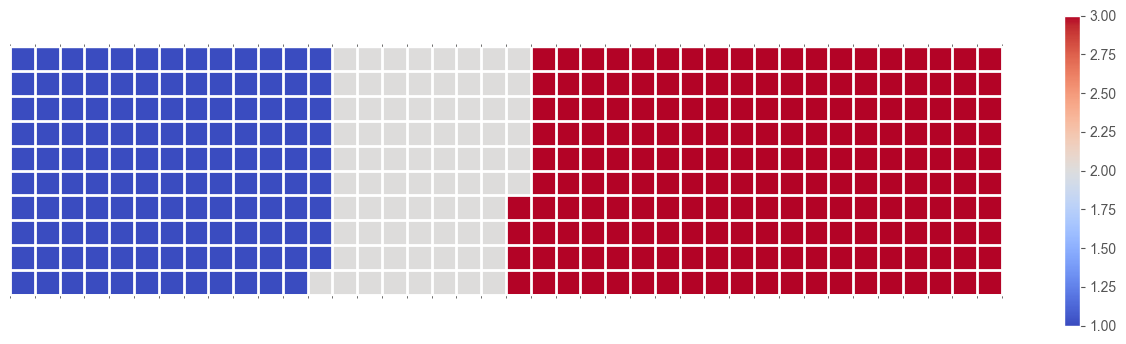

In [14]:
plt.figure()    # force to create a new canvas to avoid plot contamination
colormap = plt.get_cmap("coolwarm")
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, width, 1), minor=True)
ax.set_yticks(np.arange(-0.5, height, 1), minor=True)
ax.grid(which="minor", color="w", linestyle="-", linewidth=2)

plt.xticks([])
plt.yticks([])

<p><b>Step 7:</b> Create a legend and add it to chart.</p>

<Figure size 640x480 with 0 Axes>

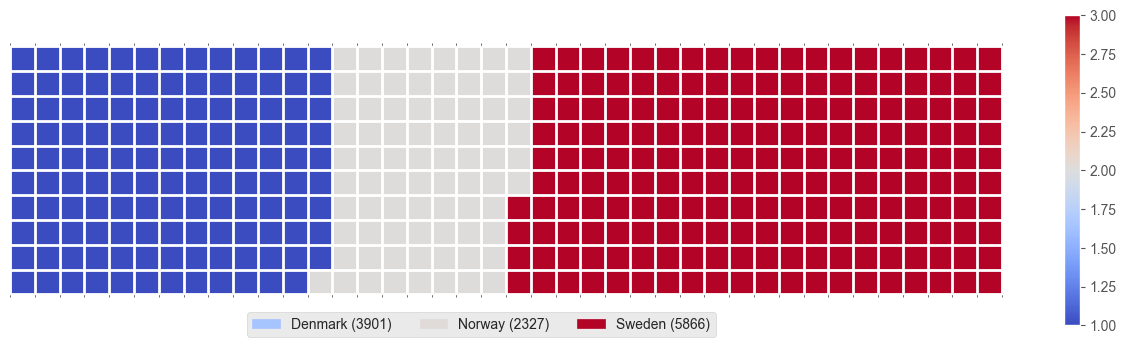

In [15]:
plt.figure()    # force to create a new canvas to avoid plot contamination

colormap = plt.get_cmap("coolwarm")
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

ax = plt.gca()

ax.set_xticks(np.arange(-0.5, width, 1), minor=True)
ax.set_yticks(np.arange(-0.5, height, 1), minor=True)
ax.grid(which="minor", color="w", linestyle="-", linewidth=2)

plt.xticks([])
plt.yticks([])

values_cs = np.cumsum(df_DNS.loc[:, "Total"])
total_values = values_cs.iloc[len(values_cs) - 1]

legend_handles = []
for i, category in enumerate(df_DNS.index.values):
    label_str = category + " (" + str(df_DNS.loc[:, "Total"].iloc[i]) + ")"
    color_val = colormap(float(values_cs.iloc[i]) / total_values)
    legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

plt.legend(handles=legend_handles, loc="lower center", ncol=len(df_DNS.index.values), bbox_to_anchor=(0.0, -0.2, 0.95, 0.1))

<p>And there you go! What a good looking <b>delicious</b> waffle chart, don't you think?</p>

<p>Now it would very inefficient to repeat these seven steps every time we wish to create a waffle chart. So let's combine all seven steps into one function called <code>create_waffle_chart()</code>. This function would take the following parameters as input:</p>
<ol>
    <li><b>cgs</b>: Unique categories or classes in dataframe.</li>
    <li><b>vals</b>: Values corresponding to categories or classes.</li>
    <li><b>hei</b>: Defined height of waffle chart.</li>
    <li><b>wid</b>: Defined width of waffle chart.</li>
    <li><b>v_sign</b>: In order to make our function more generalizable, we will add this parameter to address signs that could be associated with a value such as <code>%</code>, <code>$</code>, and so on. <code>value_sign</code> has a default value of empty string.</li>
</ol>

In [16]:
def create_waffle_chart(cgs: np.ndarray, vals: pd.Series, hei: int, wid: int, v_sign: str = "") -> None:
    cg_proportions = [(float(value) / sum(vals)) for value in vals]

    total_no_tiles = wid * hei
    print("Total number of tiles: ", total_no_tiles)

    tiles_per_cg = [round(proportion * total_no_tiles) for proportion in cg_proportions]

    for index, tiles in enumerate(tiles_per_cg):
        print(f"{df_DNS.index.values[index]}: {str(tiles)}")

    waf_chart = np.zeros((hei, wid), dtype=np.uint)

    _cg_index = 0
    _tile_index = 0

    for c in range(wid):    # column
        for r in range(hei):    # row
            _tile_index += 1

            if _tile_index > sum(tiles_per_cg[0: _cg_index]):
                _cg_index += 1

            waf_chart[r, c] = _cg_index

    plt.figure()    # force to create a new canvas to avoid plot contamination

    cm = plt.get_cmap("coolwarm")
    plt.matshow(waf_chart, cmap=cm)
    plt.colorbar()

    axes = plt.gca()
    axes.set_xticks(np.arange(-0.5, wid, 1), minor=True)
    axes.set_yticks(np.arange(-0.5, hei, 1), minor=True)
    axes.grid(which="minor", color="w", linestyle="-", linewidth=2)

    plt.xticks([])
    plt.yticks([])

    val_cs = np.cumsum(vals)
    total_val = val_cs.iloc[len(val_cs) - 1]

    legend_hds = []
    for index, cg in enumerate(cgs):
        if v_sign == "%":
            label = cg + " (" + str(vals.iloc[index]) + v_sign + ")"
        else:
            label = cg + " (" + v_sign + str(vals.iloc[index]) + ")"

        col_val = cm(float(val_cs.iloc[index]) / total_val)
        legend_hds.append(mpatches.Patch(color=col_val, label=label))

    plt.legend(handles=legend_hds, loc="lower center", ncol=len(cgs), bbox_to_anchor=(0.0, -0.2, 0.95, 0.1))

<p>Now to create a waffle chart, all we have to do is call the function <code>create_waffle_chart()</code>.</p>

Total number of tiles:  400
Denmark: 129
Norway: 77
Sweden: 194


<Figure size 640x480 with 0 Axes>

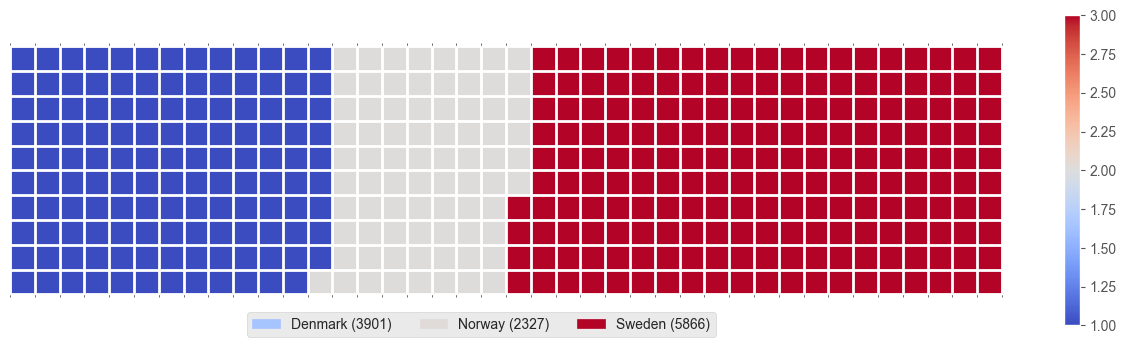

In [17]:
create_waffle_chart(cgs=df_DNS.index.values, vals=df_DNS.loc[:, "Total"], hei=10, wid=40)

<p>There seems to be a new Python package for generating waffle charts called <a href="https://github.com/ligyxy/PyWaffle">PyWaffle</a>. Let's create the same waffle chart with <code>pywaffle</code> now.</p>

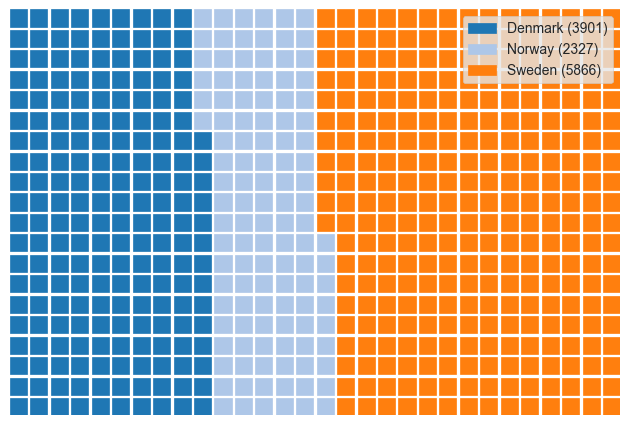

In [18]:
plt.figure(FigureClass=Waffle, rows=20, columns=30, values=df_DNS.loc[:, "Total"], cmap_name="tab20", legend={"labels": [f"{k} ({v})" for k, v in zip(df_DNS.index.values, df_DNS.loc[:, "Total"])]})

plt.show()  # fix duplicate display issue

<p><b>Question:</b> Create a waffle chart to display the proportion of China and India total immigrant contribution.</p>

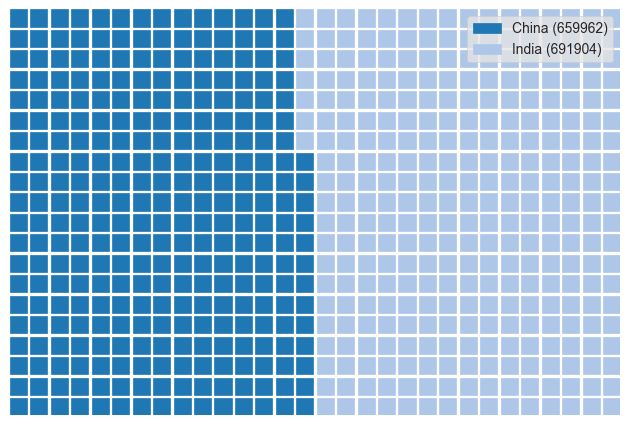

In [19]:
df_CI = df.loc[["China", "India"], :]

plt.figure(FigureClass=Waffle, rows=20, columns=30, values=df_CI.loc[:, "Total"], cmap_name="tab20", legend={"labels": [f"{k} ({v})" for k, v in zip(df_CI.index.values, df_CI.loc[:, "Total"])]})

plt.show()  # fix duplicate display issue

## Word Clouds

<p><code>Word</code> clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.</p>
<p>Luckily, a Python package already exists in Python for generating <code>word clouds</code>. The package, called <code>word_cloud</code> was developed by <b>Andreas Mueller</b>. You can learn more about the package by following <a herf="https://github.com/amueller/word_cloud/">this link</a>.

<p>Let's use this package to learn how to generate a word cloud for a given text document.</p>

In [20]:
data_url_2 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/alice_novel.txt"
alice_novel_file = download_file(data_url_2)

Downloading: 100.00% (145192 / 145192 bytes)
Download Complete.


In [21]:
with open(alice_novel_file, "r", encoding="utf-8") as f:
    alice_novel = f.read()

<p>Next, let's use the stopwords that we imported from <code>word_cloud</code>. We use the function <code>set()</code> to remove any redundant stopwords.</p>

In [22]:
stopwords = set(STOPWORDS)

<p>Create a word cloud object and generate a word cloud. For simplicity, let's generate a word cloud using only the first 2000 words in the novel.</p>

In [23]:
alice_wc = WordCloud(stopwords=stopwords)
alice_wc.generate(alice_novel)

<p>Awesome! Now that the word cloud is created, let's visualize it.</p>

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

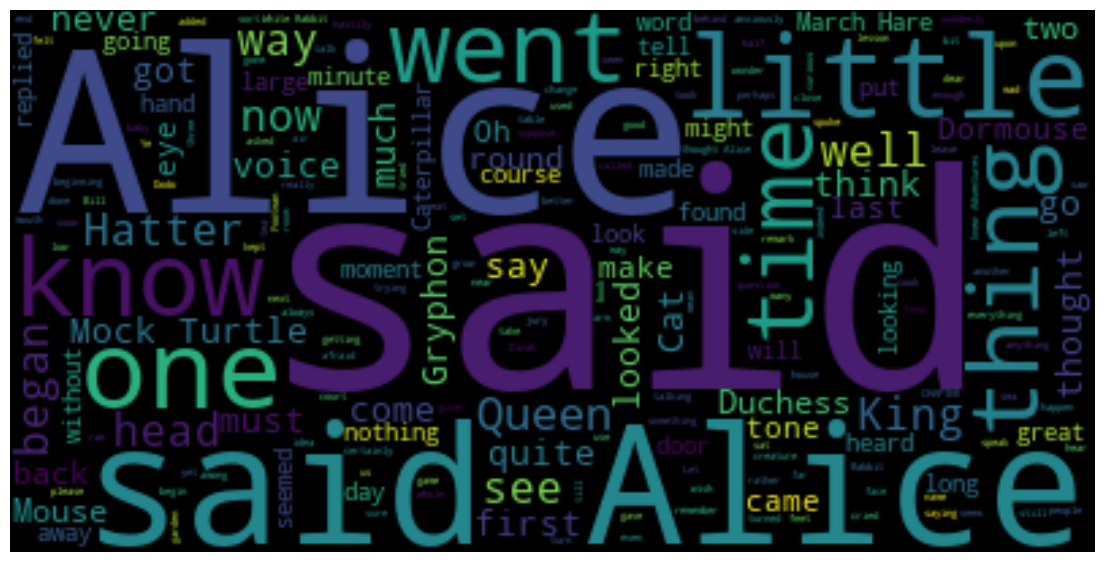

In [24]:
plt.figure(figsize=(14, 10))

plt.imshow(alice_wc, interpolation="bilinear")
plt.axis("off")

<p>Interesting! So in the first 2000 words in the novel, the most common words are <b>Alice</b>, <b>said</b>, and so on. Let's resize the cloud so that we can see the less frequent words a little better.</p>

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

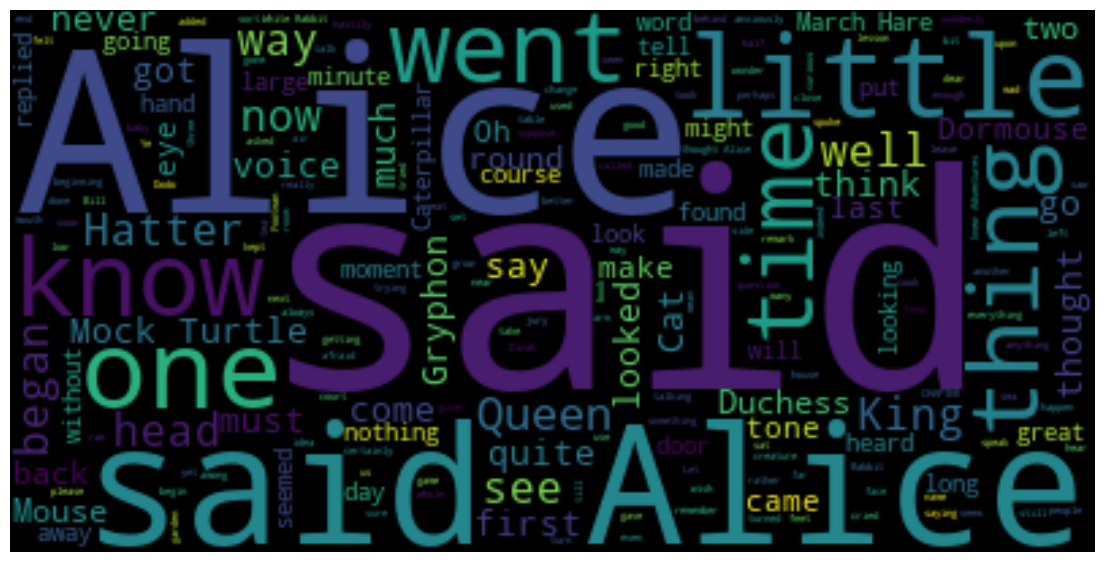

In [25]:
plt.figure(figsize=(14, 18))    # force to create a new canvas to avoid plot contamination

plt.imshow(alice_wc, interpolation="bilinear")
plt.axis("off")

<p>Much better! However, <b>said</b> isn't really an informative word. So let's add it to our stopwords and re-generate the cloud.</p>

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

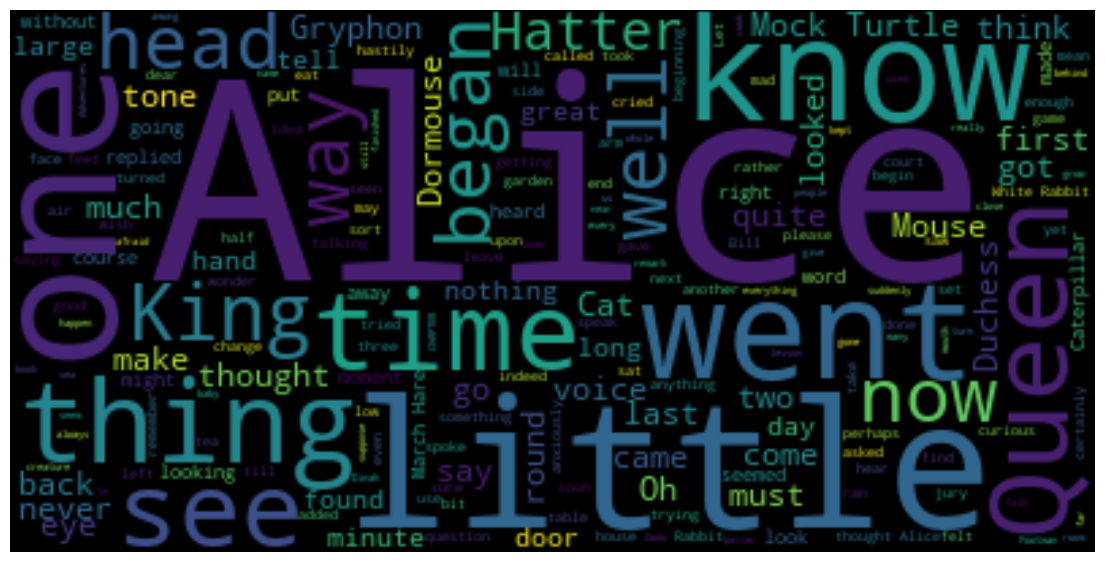

In [26]:
stopwords.add("said")
alice_wc = WordCloud(stopwords=stopwords)
alice_wc.generate(alice_novel)

plt.figure(figsize=(14, 18))

plt.imshow(alice_wc, interpolation="bilinear")
plt.axis("off")

<p>Excellent! This looks really interesting! Another cool thing you can implement with the <code>word_cloud</code> package is superimposing the words onto a mask of any shape. Let's use a mask of Alice and her rabbit. We already created the mask for you, so let's go ahead and download it and call it <code>alice_mask.png</code>.</p>

In [27]:
data_url_3 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/labs/Module%204/images/alice_mask.png"
alice_mask_file = download_file(data_url_3)

Downloading: 100.00% (7339 / 7339 bytes)
Download Complete.


In [28]:
alice_mask = np.array(Image.open(alice_mask_file))

<p>Let's take a look at how the mask looks like.</p>

(np.float64(-0.5), np.float64(899.5), np.float64(899.5), np.float64(-0.5))

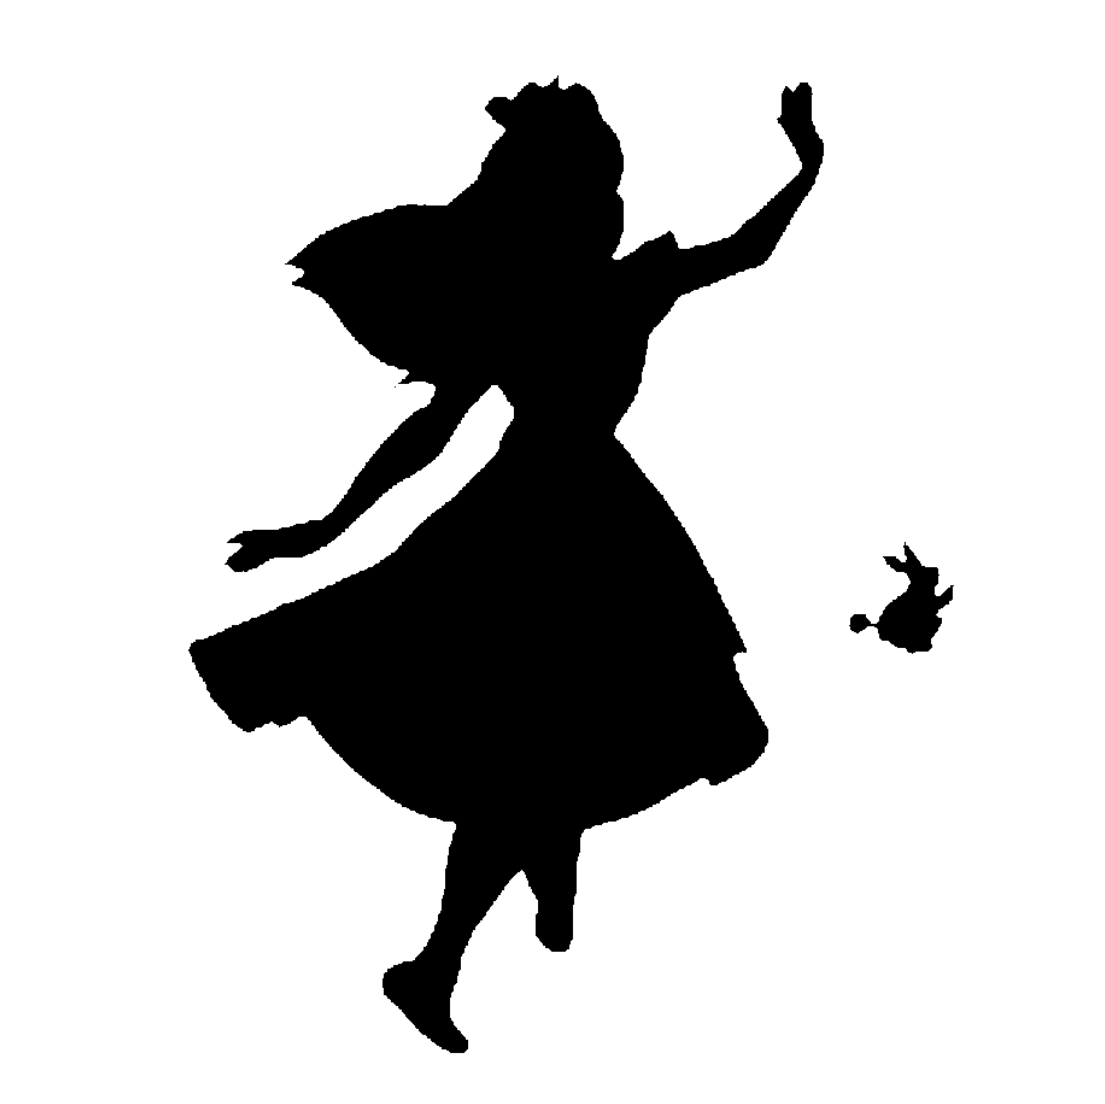

In [29]:
plt.figure(figsize=(14, 18))    # force to create a new canvas to avoid plot contamination

plt.imshow(alice_mask, cmap=plt.get_cmap("gray"), interpolation="bilinear")
plt.axis("off")

<p>Shaping the word cloud according to the mask is straightforward using <code>word_cloud</code> package. For simplicity, we will continue using the first 2000 words in the novel.</p>

(np.float64(-0.5), np.float64(899.5), np.float64(899.5), np.float64(-0.5))

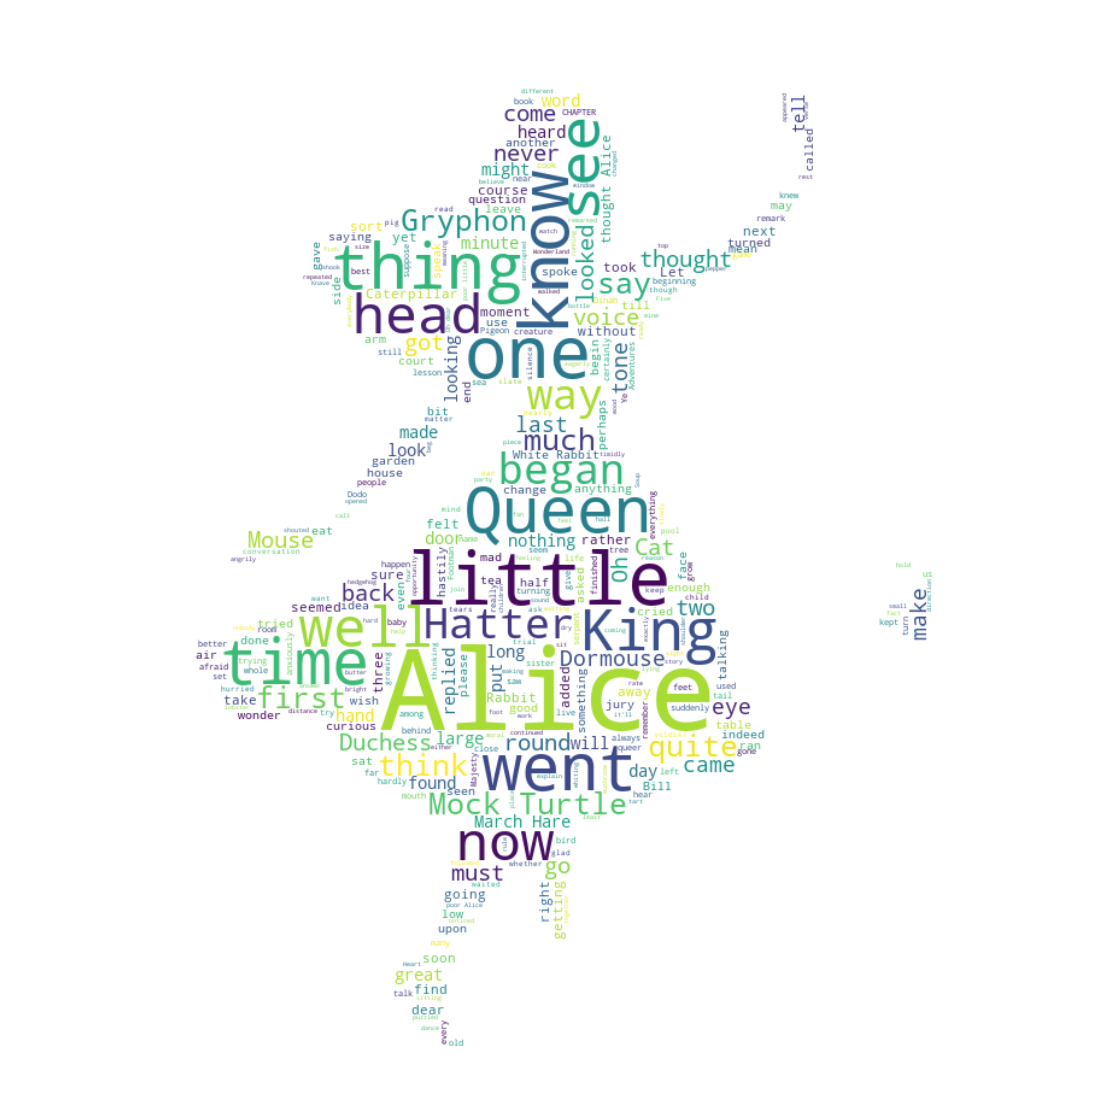

In [30]:
alice_wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask, stopwords=stopwords)
alice_wc.generate(alice_novel)

plt.figure(figsize=(14, 18))    # force to create a new canvas to avoid plot contamination

plt.imshow(alice_wc, interpolation="bilinear")
plt.axis("off")

<p>Really impressive!</p>
<p>Unfortunately, our immigration does not have any text data, but where there is a will there is a way. Let's generate sample text data from our immigration dataset, say text data of 90 words.</p>
<p>Let's recall how our data looks like.</p>

In [31]:
df.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


<p>And what was the total immigration from 1980 to 2013?</p>

In [32]:
total_immigration = df.loc[:, "Total"].sum()
total_immigration

np.int64(6409153)

<p>Using countries with single-word names, let's duplicate each country's name based on how much they contribute to the total immigration.</p>

In [33]:
max_words = 90
word_string = ""

for country in df.index.values:
    if country.count(" ") == 0:
        repeat_num_times = int(df.loc[country, "Total"] / total_immigration * max_words)
        word_string += (country + " ") * repeat_num_times

word_string

'China China China China China China China China China Colombia Egypt France Guyana Haiti India India India India India India India India India Jamaica Lebanon Morocco Pakistan Pakistan Pakistan Philippines Philippines Philippines Philippines Philippines Philippines Philippines Poland Portugal Romania '

<p>We are not dealing with any stopwords here, so there is no need to pass them when creating the word cloud.</p>

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

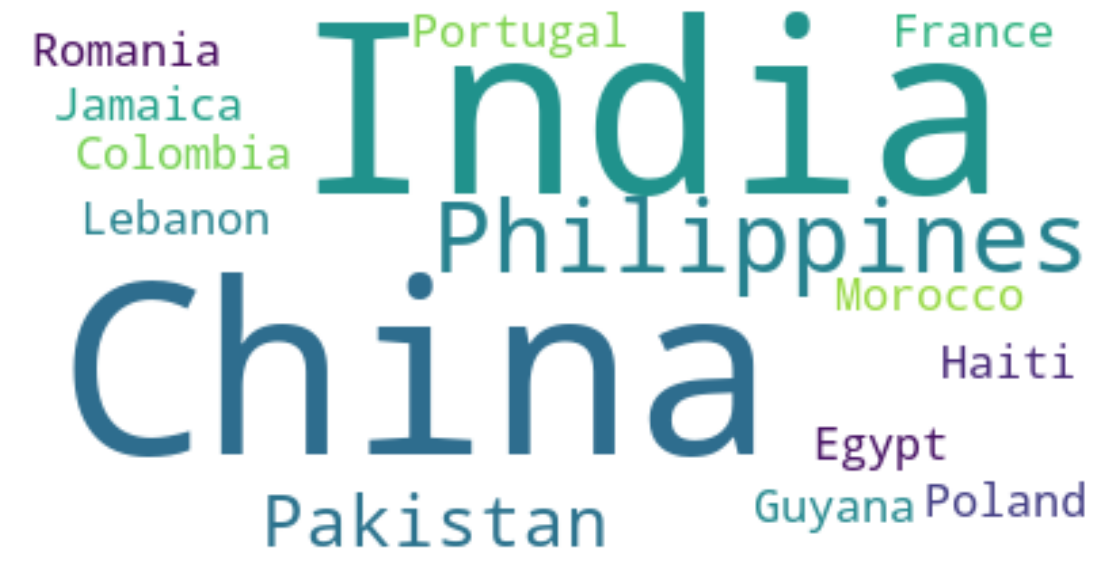

In [34]:
country_wc = WordCloud(background_color="white").generate(word_string)

plt.figure(figsize=(14, 18))

plt.imshow(country_wc, interpolation="bilinear")
plt.axis("off")

<p>According to the above word cloud, it looks like the majority of the people who immigrated came from one of 15 countries that are displayed by the word cloud. One cool visual that you could build, is perhaps using the map of Canada and a mask and superimposing the word cloud on top of the map of Canada. That would be an interesting visual to build!</p>

## Plotting with `seaborn`

<p><code>Seaborn</code> is a Python visualization library based on <code>matplotlib</code>. It provides a high-level interface for drawing attractive statistical graphics. You can learn more about <code>seaborn</code> by following <a href="https://seaborn.pydata.org/">this link</a> and more about <code>seaborn regression plots</code> by following <a href="https://seaborn.pydata.org/generated/seaborn.regplot.html">this link</a>.

<p>In lab <code>Pie Charts, Box Plots, Scatter Plots, and Bubble Plots</code> (in module 2), we learned how to create a scatter plot and then fit a regression line. It took about 20 lines of code to create the scatter plot along with the regression fit. In this final section, we will explore <code>seaborn</code> and see how efficient it is to create regression lines and fits using this library!</p>

### Categorical Plots

<p>In our data <code>df</code>, let's find out how many continents are mentioned.</p>

In [35]:
df.loc[:, "Continent"].unique()

array(['Asia', 'Europe', 'Africa', 'Oceania',
       'Latin America and the Caribbean', 'Northern America'],
      dtype=object)

### `seaborn.countplot()`

<p>A <code>count</code> plot can be thought of as a histogram across a categorical, instead of quantitative, variable. Let's find the count of Continents in the data <code>df</code> using <code>countplot()</code> on <code>Continent</code>.</p>

<Axes: xlabel='Continent', ylabel='count'>

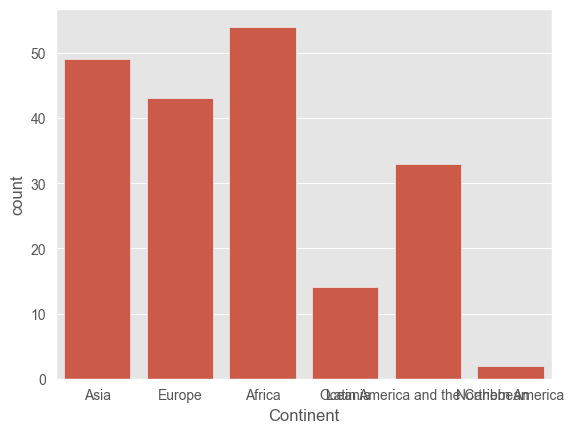

In [36]:
sns.countplot(x="Continent", data=df)

<p>The labels on the x-axis does not look as expected. Let's try to replace the <code>Latin America and the Caribbean</code> with <code>L-America</code>, and replace <code>Northern America</code> with <code>N-America</code>. And change the figure size and then display the plot again.</p>

In [37]:
df_1 = df.replace("Latin America and the Caribbean", "L-America")
df_1 = df_1.replace("Northern America", "N-America")

<Axes: xlabel='Continent', ylabel='count'>

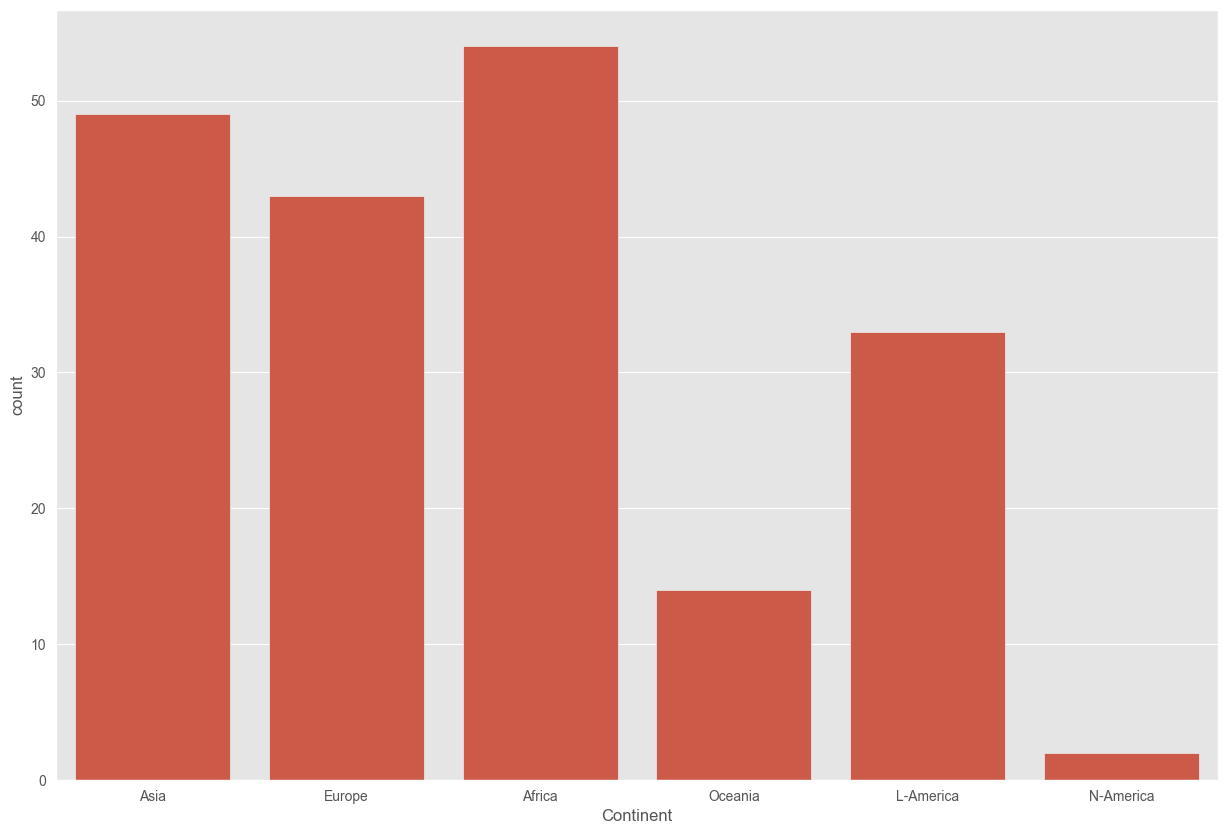

In [38]:
plt.figure(figsize=(15, 10))
sns.countplot(x="Continent", data=df_1)

<p>Much better!</p>

### `seaborn.barplot()`

<p>This plot will perform the <code>groupby()</code> on a categorical variable and plot aggregated values, with confidence intervals.</p>
<p>Let's plot the total immigrants <code>Continent-wise</code>.</p>

<Axes: xlabel='Continent', ylabel='Total'>

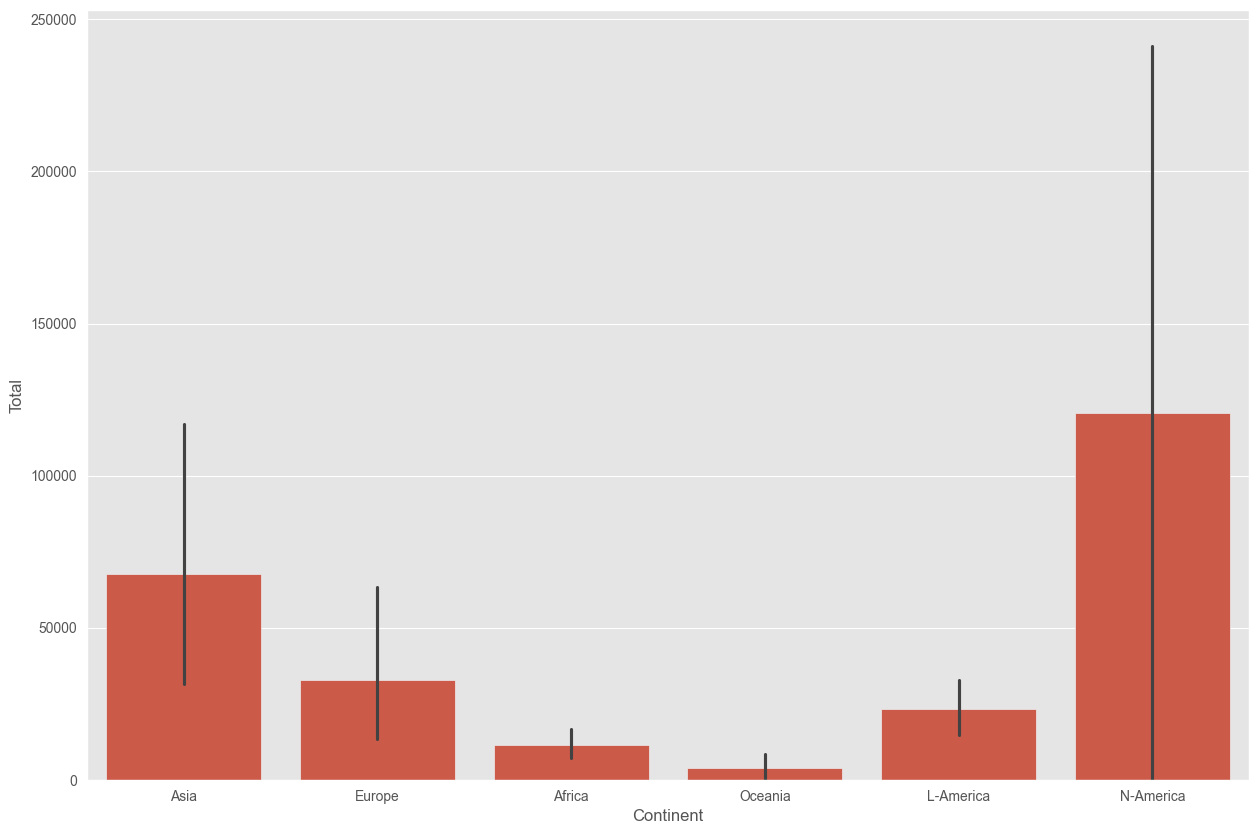

In [39]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Continent", y="Total", data=df_1)

<p>You can verify the values by performing the <code>groupby()</code> on the Total and <code>Continent</code> for <code>mean()</code>.</p>

In [40]:
df_1.groupby("Continent")["Total"].mean()

Continent
Africa        11462.000000
Asia          67710.081633
Europe        32812.720930
L-America     23186.303030
N-America    120571.000000
Oceania        3941.000000
Name: Total, dtype: float64

### `seaborn.regplot()`

<p>Generating a regression plot is as simple as calling the <code>regplot()</code> function with <code>seaborn</code>.</p>

In [41]:
years = list(map(str, range(1980, 2014)))

df_total = pd.DataFrame(df.loc[:, years].sum())
df_total.index = map(float, df_total.index)

df_total = df_total.reset_index()
df_total.columns = ["year", "total"]

df_total.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


<Axes: xlabel='year', ylabel='total'>

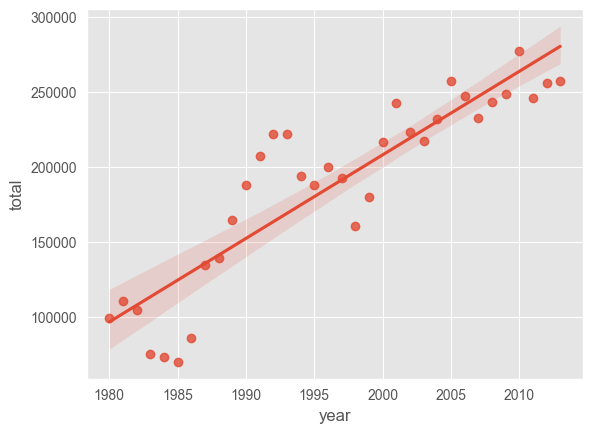

In [42]:
plt.figure()
sns.regplot(x="year", y="total", data=df_total)

<p>This is not magic. It's <code>seaborn</code>! You can also customize the color of the scatter plot and regression line. Let's change the color to green.</p>

<Axes: xlabel='year', ylabel='total'>

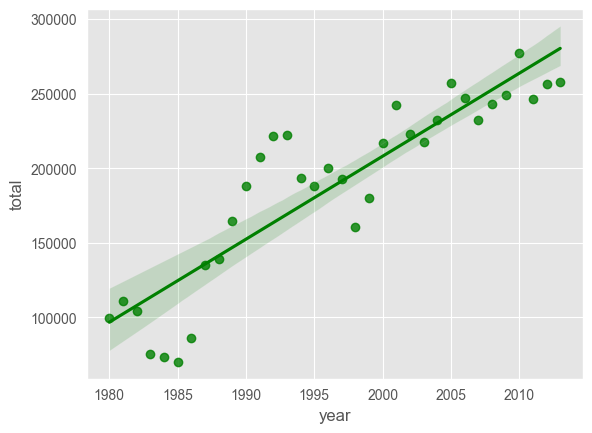

In [43]:
plt.figure()
sns.regplot(x="year", y="total", data=df_total, color="g")

<p>You can always customize the marker shape, so instead of circular markers, let's use <code>+</code>.</p>

<Axes: xlabel='year', ylabel='total'>

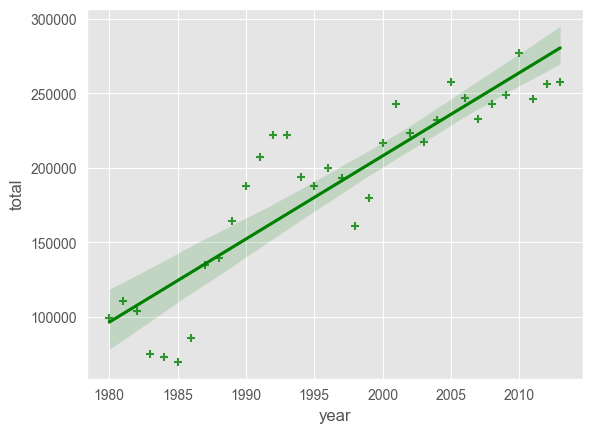

In [44]:
plt.figure()
sns.regplot(x="year", y="total", data=df_total, color="g", marker="+")

<p>Let's blow up the plot a little so that it is more appealing to the sight.</p>

<Axes: xlabel='year', ylabel='total'>

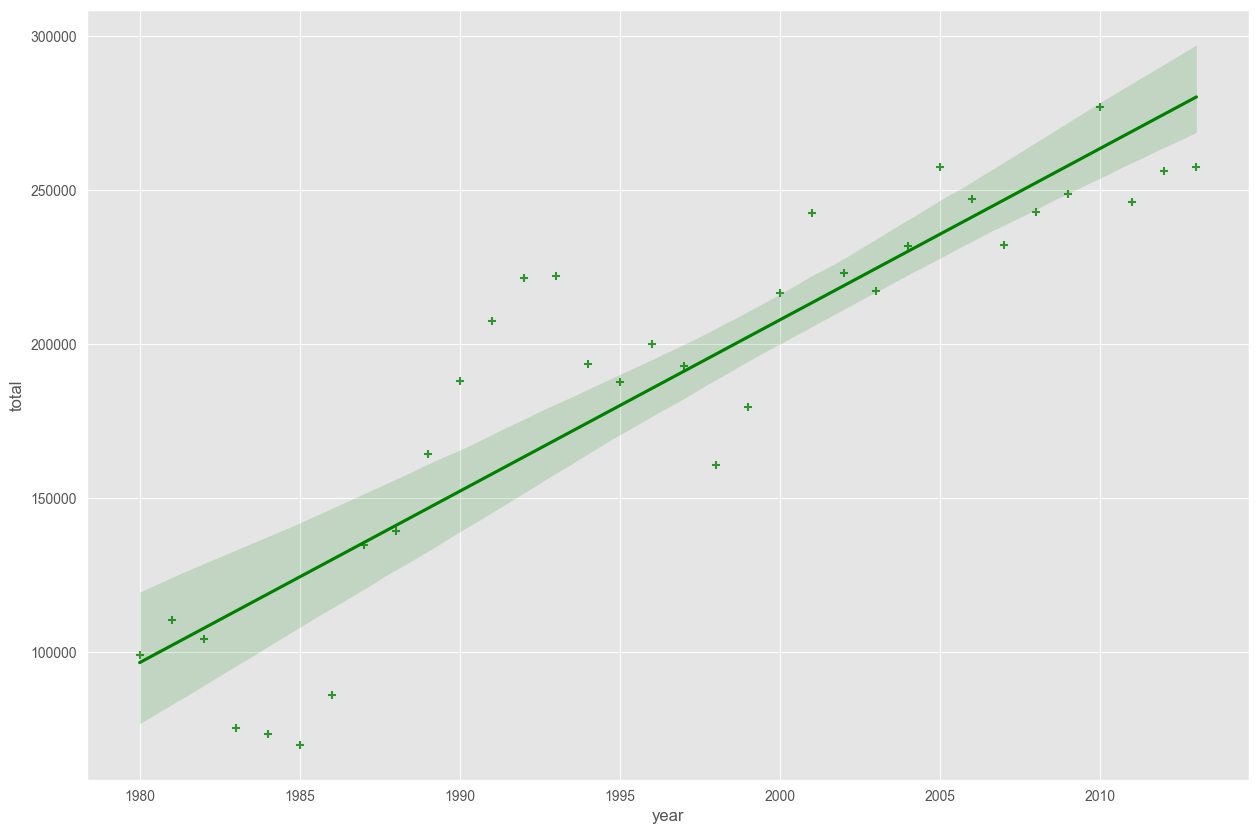

In [45]:
plt.figure(figsize=(15, 10))
sns.regplot(x="year", y="total", data=df_total, color="g", marker="+")

<p>And let's increase the size of markers so they match the new size of the figure, and add a title and x- and y-labels.</p>

Text(0.5, 1.0, 'Total Immigration to Canada [1980-2013]')

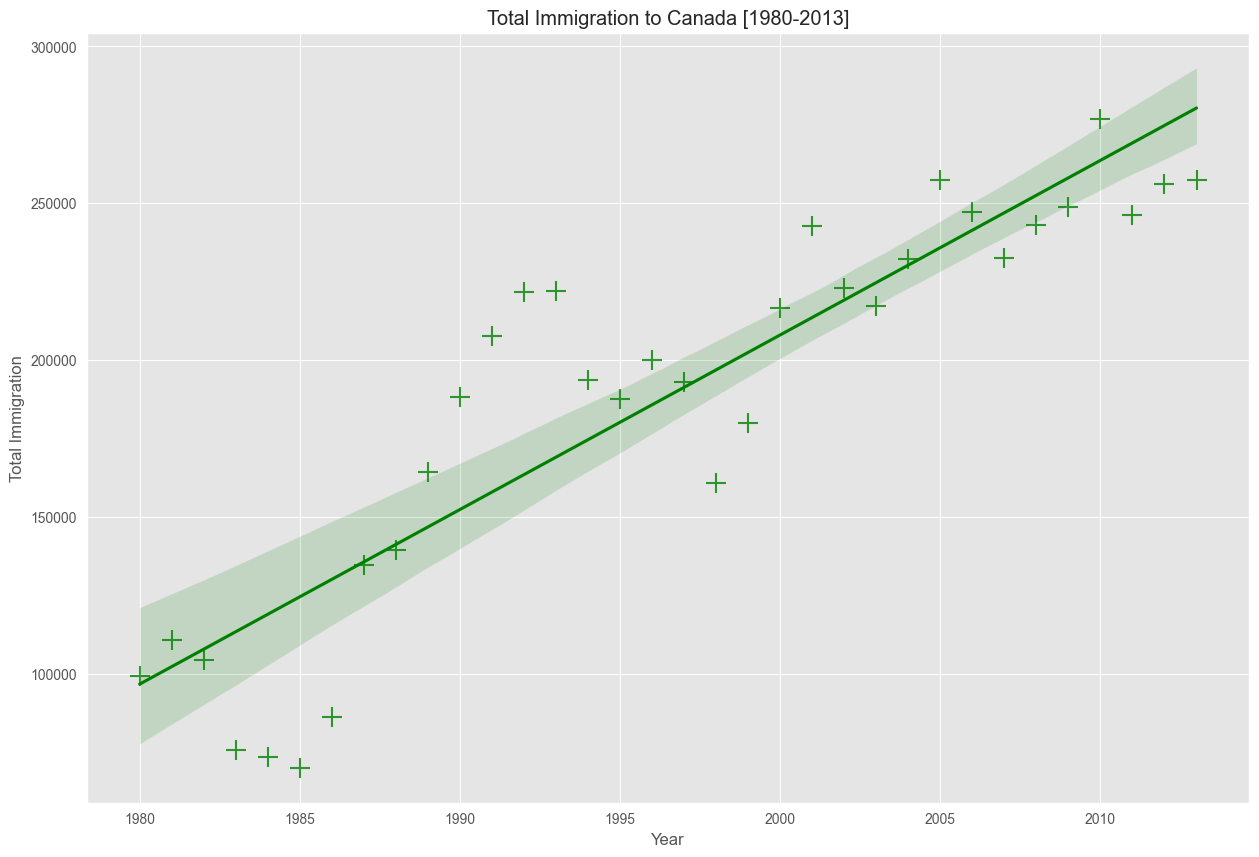

In [46]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(x="year", y="total", data=df_total, color="g", marker="+", scatter_kws={"s": 200})
ax.set(xlabel="Year", ylabel="Total Immigration")
ax.set_title("Total Immigration to Canada [1980-2013]")

<p>And finally increase the font size of the tick mark labels, the title and the x- and y-labels so they don't feel left out!</p>

Text(0.5, 1.0, 'Total Immigration to Canada [1980-2013]')

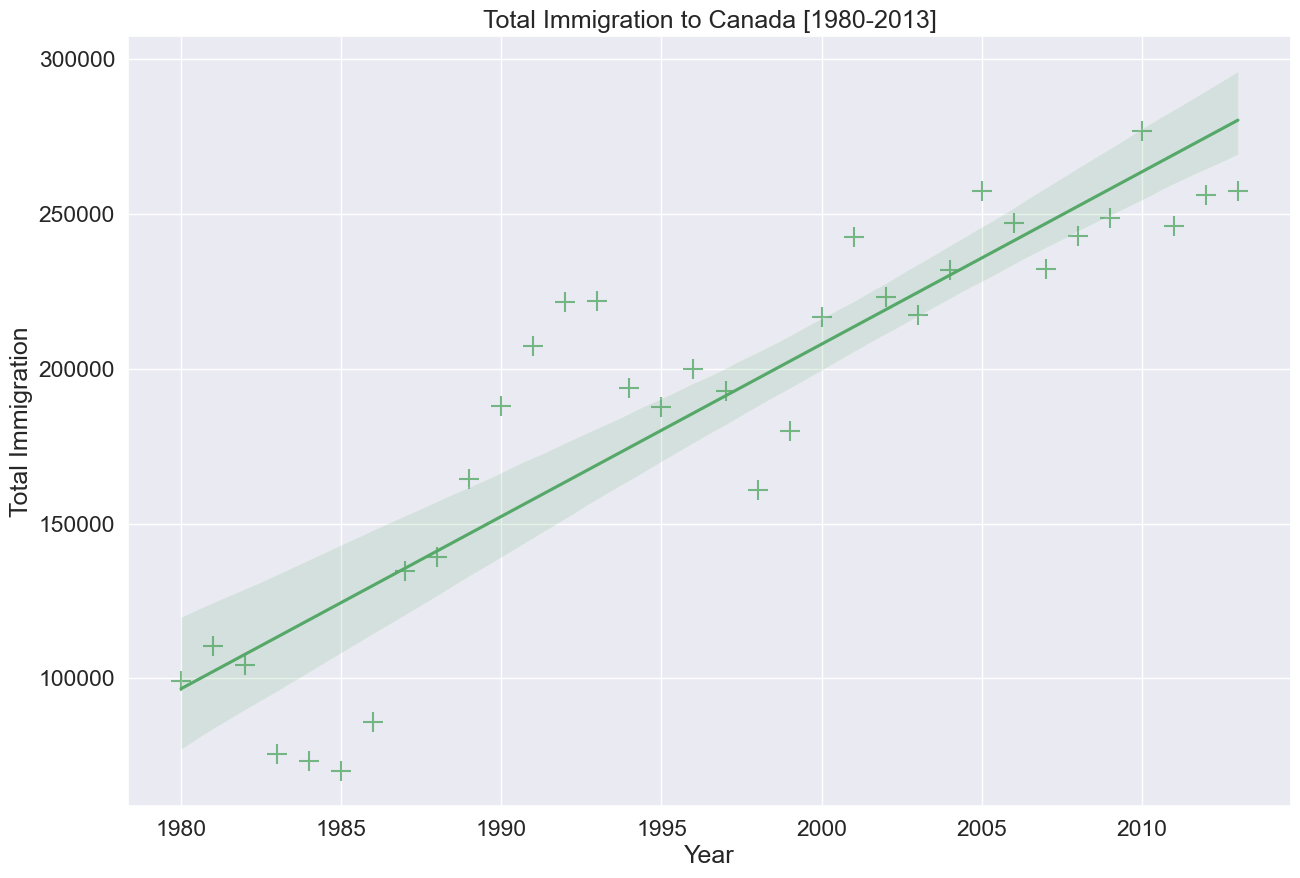

In [47]:
plt.figure(figsize=(15, 10))

sns.set_theme(font_scale=1.5)

ax = sns.regplot(x="year", y="total", data=df_total, color="g", marker="+", scatter_kws={"s": 200})
ax.set(xlabel="Year", ylabel="Total Immigration")
ax.set_title("Total Immigration to Canada [1980-2013]")

<p>Amazing! A complete scatter plot with a regression fit with 5 lines of code only. Isn't this really amazing?</p>
<p>If you are not a big fan of the purple background, you can easily change the style to a white plain background.</p>

Text(0.5, 1.0, 'Total Immigration to Canada [1980-2013]')

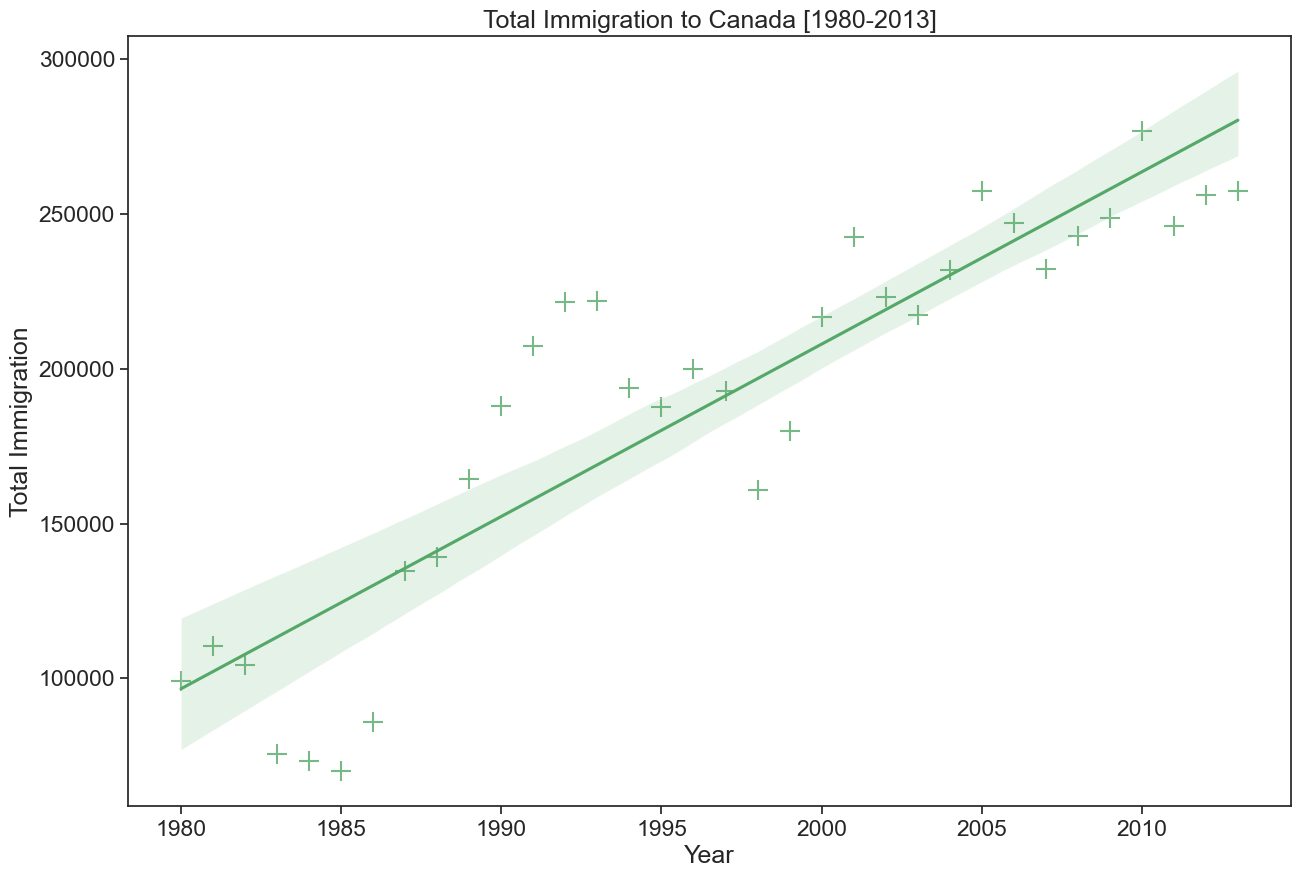

In [48]:
plt.figure(figsize=(15, 10))

sns.set_theme(font_scale=1.5)
sns.set_style("ticks")

ax = sns.regplot(x="year", y="total", data=df_total, color="g", marker="+", scatter_kws={"s": 200})
ax.set(xlabel="Year", ylabel="Total Immigration")
ax.set_title("Total Immigration to Canada [1980-2013]")

<p>Or to a white background with gridlines.</p>

Text(0.5, 1.0, 'Total Immigration to Canada [1980-2013]')

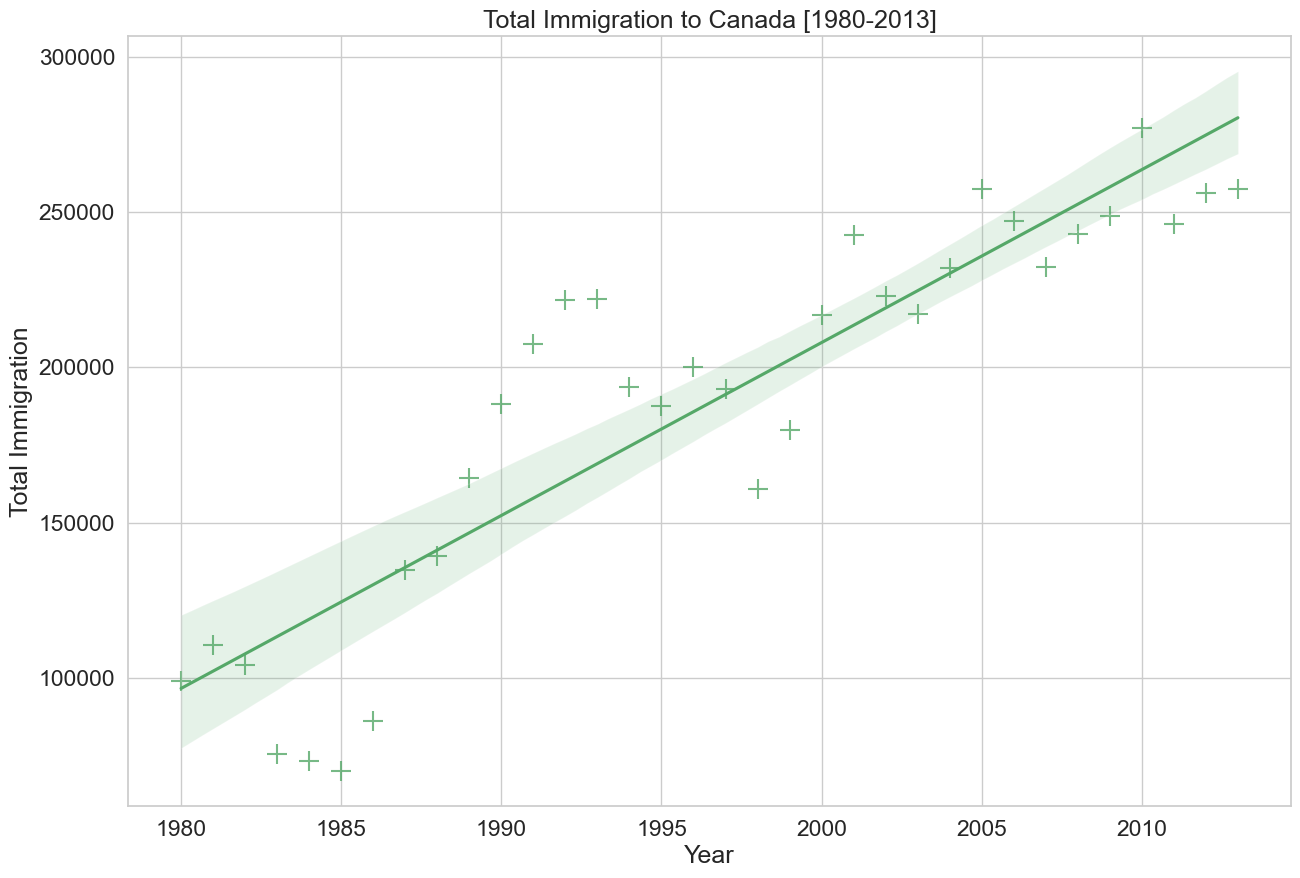

In [49]:
plt.figure(figsize=(15, 10))

sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid")

ax = sns.regplot(x="year", y="total", data=df_total, color="g", marker="+", scatter_kws={"s": 200})
ax.set(xlabel="Year", ylabel="Total Immigration")
ax.set_title("Total Immigration to Canada [1980-2013]")

<p><b>Question:</b> Use <code>seaborn</code> to create a scatter plot with a regression line to visualize the total immigration from Denmark, Sweden, and Norway to Canada from 1980 to 2013.</p>

Text(0.5, 1.0, 'Total Immigration from Denmark, Sweden, and Norway to Canada [1980-2013]')

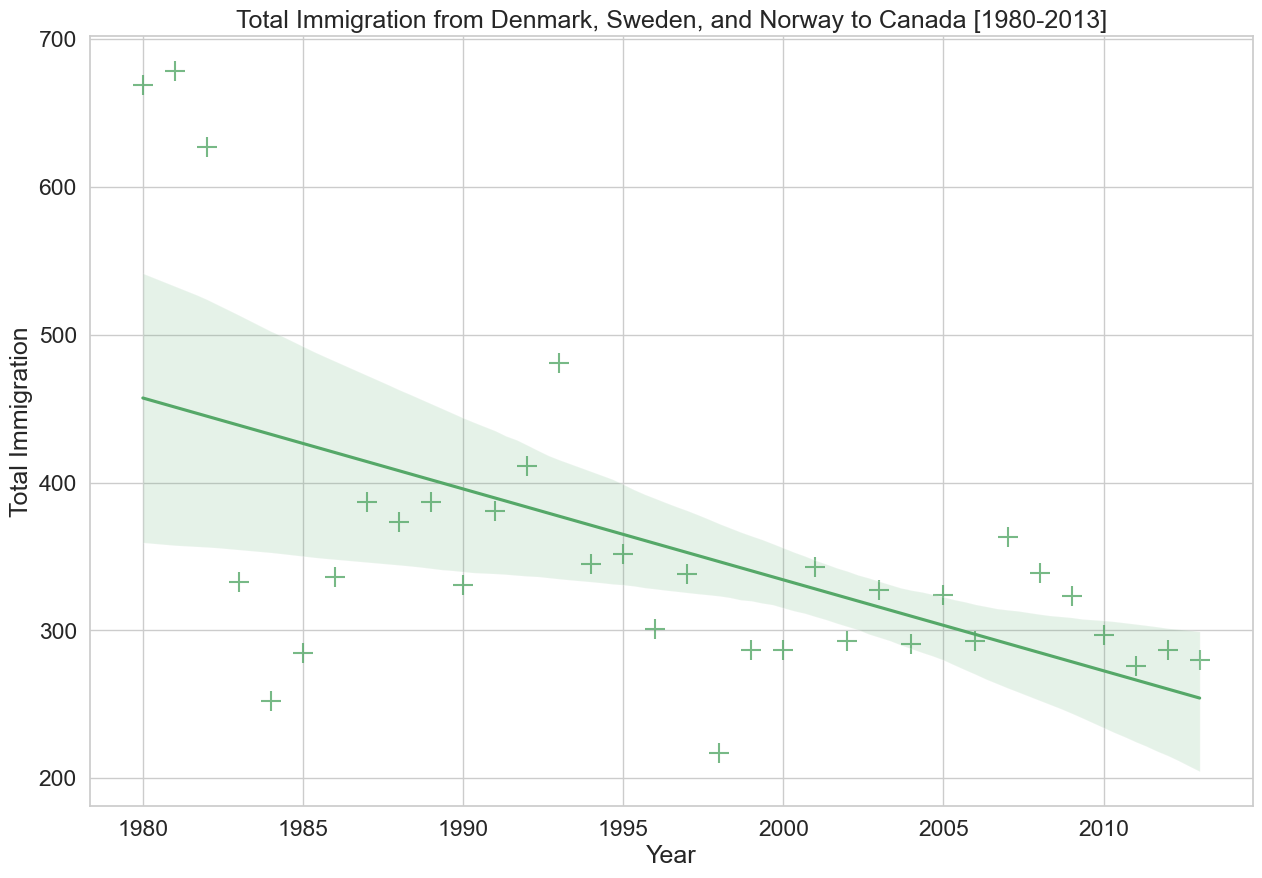

In [50]:
df_DNS = df.loc[["Denmark", "Norway", "Sweden"], years].transpose()
df_DNS_total = pd.DataFrame(df_DNS.sum(axis=1))
df_DNS_total = df_DNS_total.reset_index()
df_DNS_total.columns = ["year", "total"]
df_DNS_total["year"] = df_DNS_total["year"].astype(int)

plt.figure(figsize=(15, 10))
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid")

ax = sns.regplot(x="year", y="total", data=df_DNS_total, color="g", marker="+", scatter_kws={"s": 200})
ax.set(xlabel="Year", ylabel="Total Immigration")
ax.set_title("Total Immigration from Denmark, Sweden, and Norway to Canada [1980-2013]")

****
This is the end of the file.
****